<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Lections/07L_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генеративно-состязательные нейронные сети (GAN)

В прошлый раз мы познакомились с автоэнкодерами и в том числе с возможностью использовать их как генераторы новых объектов: обучив автоэнкодер мы можем брать случайные вектора из выученного им латентного пространства и подавать их на вход декодеру, получая на выходе объекты, похожие на те, которые мы "учили".

Таким образом мы можем оценивать свойства выученного кодировщиком латентного пространства, проводить гладкую интерполяцию между объектами, проводить в латентном пространстве операции переноса стиля и многое другое.


<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/autoencoders/img/generation_ae.png" width= "800px;"/>



Но есть одна проблема: **VAE сложные**.

Для реальных задач может быть очень сложно подобрать правильный лосс, компоненты лосса могут конфликтовать между собой...

Нам не всегда нужно само представление объектов, часто задача стоит только в **генерации** объектов, похожих на наш датасет. Оказывается, что ее можно эффективнее решать по другой схеме!

Забегая вперед, сразу можно сказать, что задачу генерации новых объектов нейросети умеют решать **очень** хорошо. Поиграться с примерами различных генераторов можно здесь: **https://thisxdoesnotexist.com**

## Формализуем задачу генерации.

Мы имеем неразмеченные данные, и хотим генерировать новые данные, которые будут удовлетворять следующим условиям:
* Новые данные должны быть похожи на исходные.
* Но не повторять их в точности (или повторять, при случайном стечении обстоятельств).
* Чтобы результат генерации был различным при разных запусках, нам нужен элемент случайности.

Раз нам теперь не нужен в явном виде энкодер, то, возможно, в принципе от него откажемся? Будем просто семплировать случайный шум из пространства некой заданной размерности (будем называть его **входным** латентным пространством по аналогии с автоэнкодерами) и подавать на аналог декодировщика -- генератор. ПОдавая на вход шум, а не что-то осмысленное, мы как раз и гарантируем тот самый требуемый элемент случайности.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/random_example.png" alt="Drawing" width= "400px;"/>

Как выбрать размерность и форму входного вектора?

Малая размерность входного латентного пространства (например, одно число при размерности 1) даста нам малый объем возможных состояний и генерация будет однообразной. С другой стороны, увеличивая размерность латентного пространства мы можем расширить его настолько, что при обучении модели точек в этом латентром пространстве будет настолько мало, что в основном пространство будет состоять из пустот. Тогда модель будет крайне некачественно "понимать" что ей нужно генерировать в точке, которой не было на обучающей выборке.

Лучший способ выбрать длину вектора - это посмотреть похожую задачу в публикациях, взять подобную размерность, и начать экспериментировать с размерностью от этой отправной точки.

То же самое справедливо и для выбора формы входного латентного пространства, однако в общем случае выбор многомерного номального распределения в теории будет лучше восприниматься весами модели и увеличит сходимость.

## Наивный подход и его проблемы

Рассмотрим очень простой пример: попробуем создать генератор точек на параболе.
Стразу стоит отметить, что пример **так себе** -- мы и так в точности знаем правило, генерирующее нам параболу, нет никакого смысла искать его при помощи нейросетей! В реальных же задачах мы *в точности* не знаем, по какому правилу наши объекты устроены, и не сможем вообще штрафовать нашу модель за генерацию чего-то неправильного. Однако, этот пример достаточно наглядный, и, как мы увидим дальше, уже на нем удается показать что без модификаций такая схема не работает. Поэтому примем все допущения и посмотрим, что получается.

Будем подавать на вход сети случайный шум, допустим, размера 3. На выходе будем ожидать точки параболы. Проверим как это будет работать.



In [ ]:
import os
import numpy as np
import math
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from IPython.display import clear_output
from PIL import Image

import torch
import torch.nn as nn
from torch import autograd
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Dataset, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
from torchvision.utils import save_image

device = "cuda"

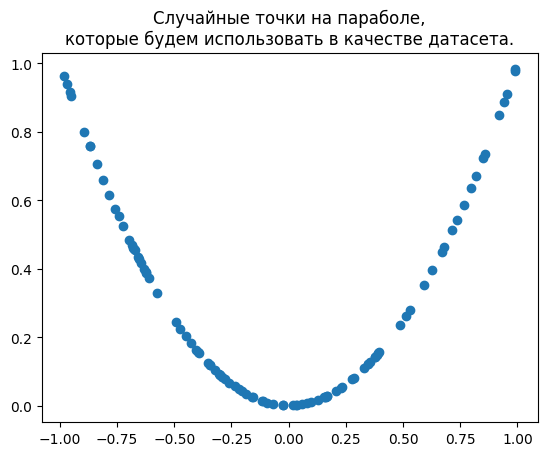

In [ ]:
def gen_pair(num=100):
    x = np.random.uniform(low=-1, high=1, size=(num,))
    y = x*x
    return np.hstack((x.reshape(-1,1), y.reshape(-1,1))) # Создадим num корректных точек (x,y) на параболе

pairs = gen_pair(100)
plt.scatter(pairs[:,0], pairs[:,1])
plt.title("Случайные точки на параболе,\nкоторые будем использовать в качестве датасета.")
plt.show()

Возьмём размерность входного латентного пространства  ls=3  и объединим шум с точками в датасеты.

In [ ]:
n_batches = 10
batch_size = 128
ls = 3 # latent space

noise = np.random.normal(size=(n_batches*batch_size, ls))
noise = torch.tensor(noise, dtype=torch.float)
print(f"NN Input: noise.shape: {noise.shape}")

xy_pair = gen_pair(num = n_batches*batch_size)
xy_pair = torch.tensor(xy_pair, dtype=torch.float)
print(f"NN Output: xy_pair.shape: {xy_pair.shape}")

dataset = TensorDataset(noise, xy_pair) # model inputs, model outputs

len_tr = int(len(dataset)*0.8)
len_tst = len(dataset) - len_tr
trainset, testset = random_split(dataset,[len_tr,len_tst])

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

NN Input: noise.shape: torch.Size([1280, 3])
NN Output: xy_pair.shape: torch.Size([1280, 2])


In [ ]:
def get_test_loss(model,test_loader,loss_function):
    with torch.no_grad():
        loss_test_total = 0
        for samples, labels in test_loader:
            outputs = model(samples.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss_test_total += loss.item()
        return loss_test_total/len(test_loader)

Определим простую модель, которая будет ожидать шум на вход, и генерировать точки на выходе. (Обратите внимание, что функция активации на последнем слое отсутствует, поскольку мы не ограничиваем наш генератор в каком-то диапазоне.)

In [ ]:
class GenModel(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50,2))

    def forward(self, x):
        return self.model(x)

In [ ]:
epochs = 300
model = GenModel(latent_space = ls)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.L1Loss().to(device)

for epoch in range(epochs):
    loss_epoch = 0
    for samples, labels in train_loader:
        #print(samples.shape)
        optimizer.zero_grad()
        outputs = model(samples.to(device))
        loss = loss_function(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()

    loss_test = get_test_loss(model,test_loader,loss_function)
    if epoch%100==0:
        print(f"Epoch={epoch} train_loss={loss_epoch/len(train_loader):.4} test_loss={loss_test:.4}")


Epoch=0 train_loss=0.3924 test_loss=0.3678
Epoch=100 train_loss=0.3615 test_loss=0.3628
Epoch=200 train_loss=0.3475 test_loss=0.3629


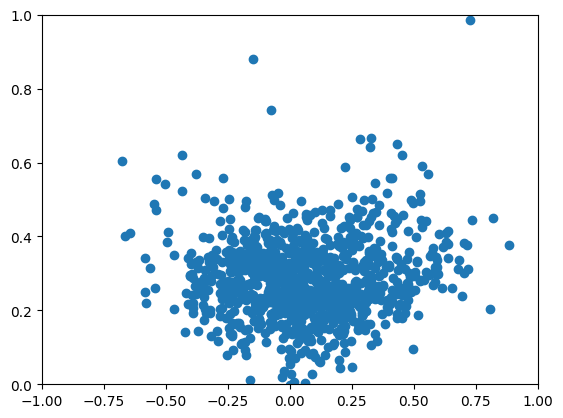

In [ ]:
def test_image(model, ls = 3):
    model.cpu()
    noice = torch.tensor(np.random.normal(size=(1000, ls)), dtype=torch.float)
    xy_pair_gen = model(noice)

    xy_pair_gen = xy_pair_gen.detach().numpy()
    plt.scatter(xy_pair_gen[:,0], xy_pair_gen[:,1])
    plt.axis([-1, 1, 0, 1])
    plt.show()
    model.to(device)
test_image(model)

Обучиться не удалось.

Как видно, результаты из рук вон плохие. Модель явно не понимает, что вне параболы точки существовать не должны. Нужно придумать, как сделать так, чтобы точки "растолкать" из области, где парабола отсутствует.

L1 loss не работает. Возможно, нам надо действовать более строго и просто штрафовать за любые точки, строго не попавшие на параболу?

Epoch=0 train_loss=0.03297 test_loss=0.02208


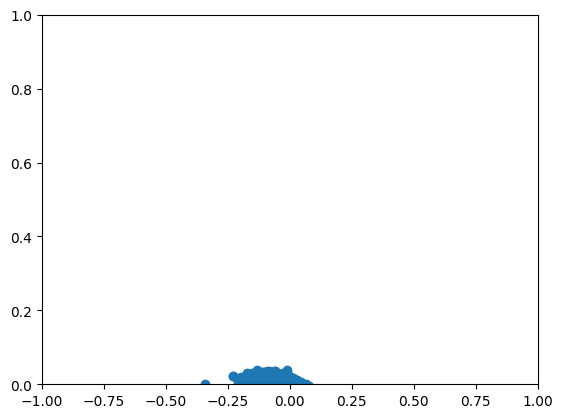

Epoch=50 train_loss=0.001337 test_loss=0.002312


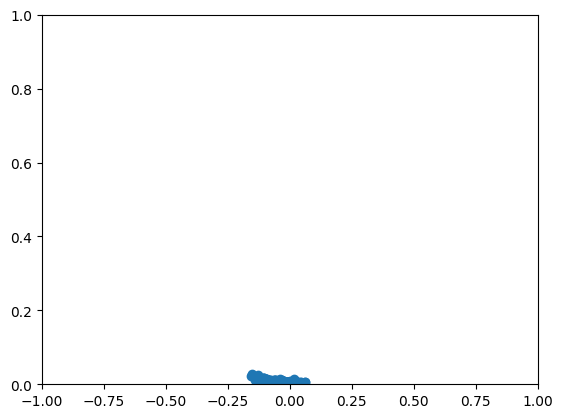

Epoch=100 train_loss=0.001845 test_loss=0.001998


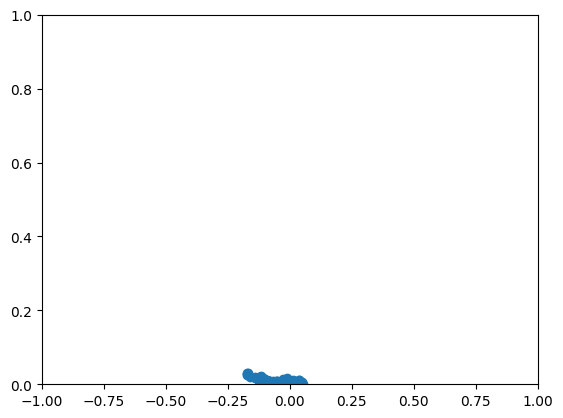

Epoch=150 train_loss=0.0013 test_loss=0.001088


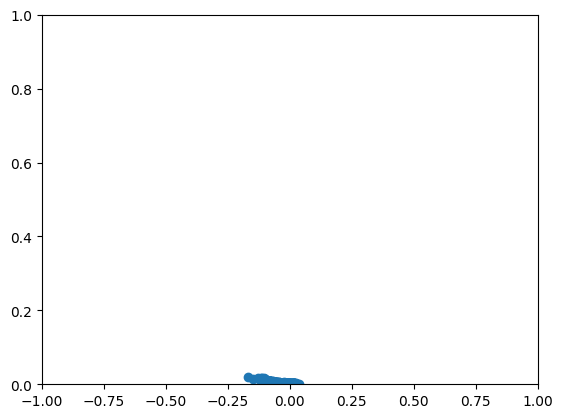

Epoch=200 train_loss=0.0009464 test_loss=0.0009843


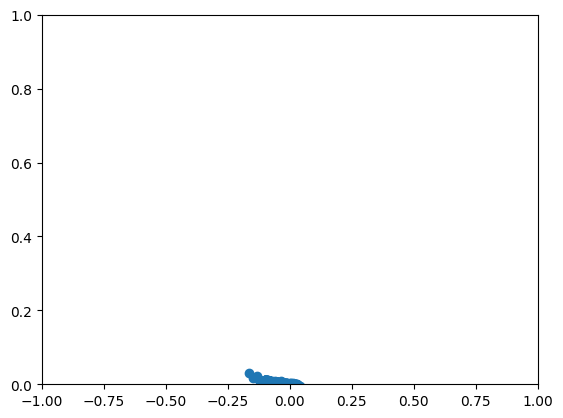

Epoch=250 train_loss=0.001364 test_loss=0.002003


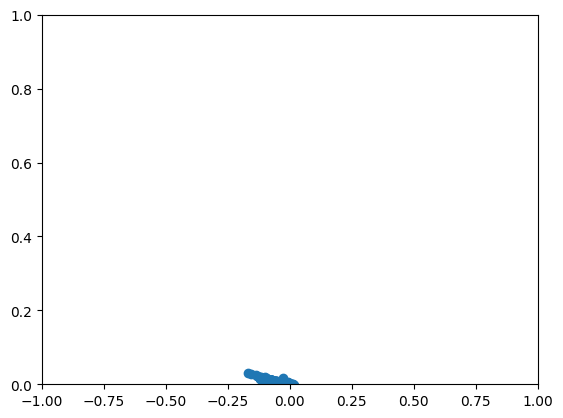

In [ ]:
def custom_losss(pair,label):
  # All inputs are batches
  x_fake = pair[:,0]
  y_fake = pair[:,1]
  return torch.abs(x_fake*x_fake - y_fake).mean() # average by batch

epochs = 300
model = GenModel(latent_space = ls)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#loss_function = nn.L1Loss().to(device)
loss_function = custom_losss

for epoch in range(epochs):
    loss_epoch = 0
    for samples, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(samples.to(device))
        loss = loss_function(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()

    loss_test = get_test_loss(model,test_loader,loss_function)
    if epoch%50==0:
        print(f"Epoch={epoch} train_loss={loss_epoch/len(train_loader):.4} test_loss={loss_test:.4}")
        test_image(model)

Опять не получилось! Вспоминаем предыдущую лекцию: нейросетки любят схитрить и пойти по пути наименьшего сопротивления. В данном случае ей удобнее всего найти удобную точку, на которой она гарантированно попадает в цель (например, 0) и порождать объекты в небольшой области вокруг нее. Неудача.

## Дискриминатор

Попробуем зайти с другой стороны. Нам нужно как-то штрафовать нашу модель за генерацию "неправильных" объектов. Обычный L1 лосс в данном случае не сработал. Жесткий штраф за несовпадение с "правильным" правилом -- тоже. И это при том, что мы точно знали, какие объекты будут правльные, а какие -- нет! В реальной жизни ситуация еще сложнее.  Нужен какой-то другой подход, в идеале самостоятельно выделяющий закономерности существования "правильных" объектов и адаптивно ужесточающий штраф по мере обучения модели.

Можем определить вторую модель, которая будет определять -- лежат точки на параболе или нет. Назовем такую модель **дискриминатор**, или критик.

In [ ]:
class DisModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 25),
            nn.ReLU(),
            nn.Linear(25, 15),
            nn.ReLU(),
            nn.Linear(15,1),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

Итого мы имеем: генератор, выдающий точки то ли попадая в параболу, то ли не попадая в неё. А так же дискриминатор, который будет учиться их различать. Поэтому мы будем подавать на генератор синтетические правильные точки, считая их реальными, и точки, которые выдаёт генератор, считая их подделкой.

Таким образом, генератор будет учиться подражать реальным данным, а дискриминатор будет учиться отличать реальные точки, от подделок.

Мы пришли к идее генеративно-состязательных нейронных сетей.

##  Generative adversarial network (GAN)

Генеративно-состязательную сеть описал Ян Гудфеллоу из компании Google в 2014 году. Сейчас он возглавляет подразделение машинного обучения в Apple. Принцип состязательности в сети GAN нередко описывается через метафоры.

Назовем нашего фальшивомонетчика $G$ (или generator), а банкира — $D$ (или discriminator). У нас есть какое-то количество оригинальных денег $X$ для банкира, и пусть на выходе у него будет число диапазоном от нуля до единицы, чтобы оно выражало уверенность банкира в том, что выданные ему на рассмотрение деньги настоящие. Еще — поскольку фальшивомонетчик у нас нейронная сеть, ей нужны какие-то входные данные, назовем их $z$ - это наш случайный шум, который модель будет стараться превратить в деньги.

![detective](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/gan_trivial_scheme.png)

Тогда, очевидно, цель фальшивомонетчика — это максимизировать $D(G(z))$, то есть сделать так, чтобы банкир был уверен, что подделки — настоящие.

Цель банкира посложнее — ему нужно одновременно положительно опознавать оригиналы, и отрицательно — подделки. Запишем это как максимизацию $D(x)(1-D(G(z)))$. Умножение можно превратить в сложение, если взять логарифм, поэтому получаем:

Для банкира: максимизировать $log(D(X))+log(1-D(G(z)))$

Для фальшивомонетчика: максимизировать $log(D(G(z)))$

![minmax loss](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/minmax_optimization_function.jpg)

Мы знаем, что дискриминатор максимизирует эту функцию относительно своих параметров $\theta_d$, где при фиксированном генераторе ${G}_{\theta_{g}}$ он выполняет бинарную классификацию: он присваивает вероятность 1 точкам данных из обучающего набора $E_{x∼p_{data}}$ и присваивает вероятность 0 сгенерированным выборкам $E_{z∼p(z)}$

Поскольку используется подход из теории игр, наша лосс-функция представлена как минимаксная функция. Дискриминатор пытается максимизировать целевую функцию, поэтому мы можем выполнить градиентный подъем целевой функции. Генератор пытается минимизировать целевую функцию, поэтому мы можем выполнить градиентный спуск для целевой функции. Посредством чередования градиентного подъема и спуска сеть можно обучить.


<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/gan_scheme.png" alt="Drawing" width= "800px;"/>

В процессе совместного конкурентного обучения, если система достаточно сбалансирована, достигается минимаксное состояние равновесия, в котором обе сети значительно улучшили своё качество, и теперь сгенерированные изображения могут быть использованы практически как настоящие.

Если же мы сначала обучим дискриминатор (сделаем его "сильным критиком"), то генератор просто не сможет обучиться.

**Преимущества GAN**
* Теоретические гарантии сходимости (показано, что лосс ГАНов при *правильном* подборе параметров обеспечивает правильную  генерацию)
* Решает в явном виде задачу generative modeling

**Недостатки GAN**
* Нестабильное обучение
* Очень долгая сходимость
* Mode-collapsing
* Generator starvation
* Поиск оптимальных параметров - **pure luck**

https://developers.google.com/machine-learning/gan/problems

https://developers.google.com/machine-learning/gan/loss

### GAN: исправляем наивный подход

Создадим две функции возвращающие батчи:

Первая функция будет создавать случайный вектор на вход генератора и метками классов будут единицы, потому что мы хотим чтобы генератор давал такие точки, чтобы классификатор их распознавал как единицы (верные). Поэтому лосс функция будет подгонять веса генератора к единицам.

In [ ]:
def get_g_batch(batch_size, latent_dim):
    g_input = torch.randn(size=(batch_size, latent_dim)).to(device)
    labels = torch.ones(size=(batch_size,)).to(device)
    return g_input, labels

Вторая функция будет давать батч на вход дискриминатора, смешивая:

* Истиные точки на параболе (чтобы обучать дискриминатор)
* Точки не на параболе (чтобы дискриминатор знал где "не парабола")
* Выход генератора как неверный (чтобы генератор не коллапсировал в одну верную точку)

In [ ]:
def get_mix_batch(batch_size, latent_dim, netG):
    types_of_points = []

    # Generate true pairs and true labels
    if True:
        x = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        true_pair = torch.vstack((x, x*x)).T.to(device)
        true_labels = torch.ones(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((true_pair, true_labels)))

    # Generate fake uniform pairs and fake labels
    # disable this to get Mode-collapsing
    if False:
        x_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        y_fake = torch.distributions.Uniform(-1, +1).sample((batch_size,)).to(device)
        fake_pair = torch.vstack((x_fake, y_fake)).T
        fake_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((fake_pair, fake_labels)))

    # Generate points from generator and set labels as fake
    if True:
        gan_pair = netG(torch.randn(size=(batch_size, latent_dim)).to(device))
        gan_labels = torch.zeros(size=(batch_size,)).unsqueeze(1).to(device)
        types_of_points.append(torch.hstack((gan_pair, gan_labels)))

    # Stack all types of points
    z = torch.vstack(types_of_points)
    # Shuffle
    z=z[torch.randperm(z.size()[0])]

    # Split back to samples and labels
    mixed_pairs = z[:, :2]
    mixed_labels = z[:, 2]
    return mixed_pairs, mixed_labels

Для удобства обернём в функции шаги backpropagation дискриминатора и генератора

In [ ]:
def netD_step(netD, batchD, loss_func, optimizer):
    samples, labels = batchD
    optimizer.zero_grad()
    outputs = netD(samples.to(device))
    loss = loss_func(outputs.to(device), labels.unsqueeze(1).detach().to(device))
    loss.backward()
    optimizer.step()

In [ ]:
def netG_step(netD, netG, batchG, loss_func, optimizer):
    samples, labels = batchG
    optimizer.zero_grad()
    outputs = netD(netG(samples.to(device)))
    loss = loss_func(outputs.to(device), labels.unsqueeze(1).detach().to(device))
    loss.backward()
    optimizer.step()

Будем каждую эпоху отображать что уже умеет генерировать генератор

In [ ]:
def plot_gen(netG, epoch="Not provided"):
    Gin, _ = get_g_batch(1000, latent_dim)
    out = netG(Gin).cpu()
    plt.scatter(out.detach().numpy()[:, 0], out.detach().numpy()[:, 1], color="blue", s=1)
    plt.title(f'Generator points. End of epoch= {epoch+1}', fontsize=10)
    plt.axis([-1,1,-0.5,1])
    plt.show()


Поскольку сети обучаются по очереди, то создадим два оптимайзера.

(Обратите внимание: в случае VAE даже когда у нас было по отдельной сети на кодировшик и декодировщий, мы обучали их вместе и оптимизатор использовали один)

In [ ]:
latent_dim = 5
batch_size = 512
batch_per_epoch = 1000
epochs = 10

netG = GenModel(latent_dim).to(device)
netD = DisModel().to(device)
loss_func = nn.BCELoss().to(device)
optD = torch.optim.Adam(netD.parameters(), lr=0.001)
optG = torch.optim.Adam(netG.parameters(), lr=0.001)

В цикле обучения будет создаваться батч данных (размера batch_size) для генератора, и батч из смеси точек (размера 3*batch_size) для дискриминатора. С балансом данных подаваемых на обе сети можно эксперементировать.

In [ ]:
def train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG):
    for epoch in range(epochs):
        for _ in range(batch_per_epoch):
            batchG = get_g_batch(batch_size, latent_dim)
            batchD = get_mix_batch(batch_size, latent_dim, netG)

            netD.train(True)
            netG.train(False)
            netD_step(netD, batchD, loss_func, optD)

            netD.train(False)
            netG.train(True)
            netG_step(netD, netG, batchG, loss_func, optG)

        # clear_output()
        plot_gen(netG, epoch)

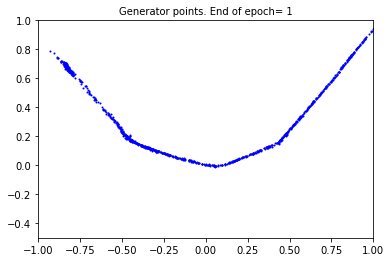

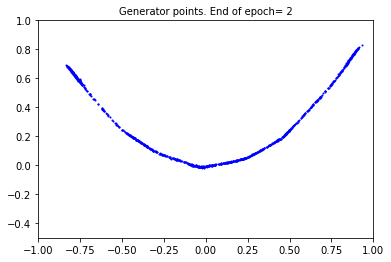

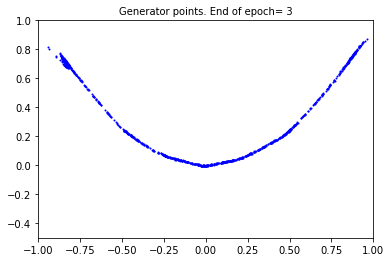

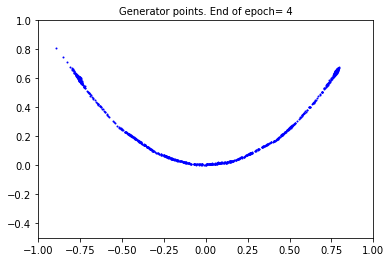

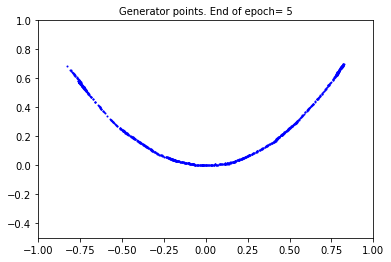

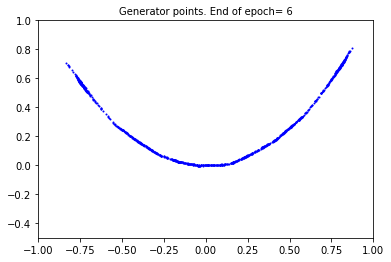

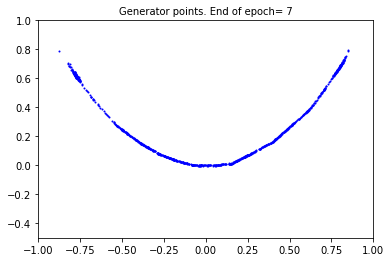

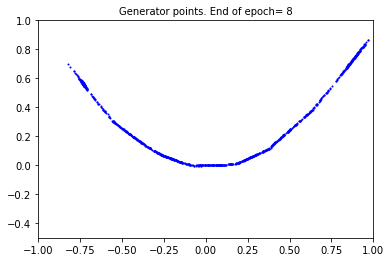

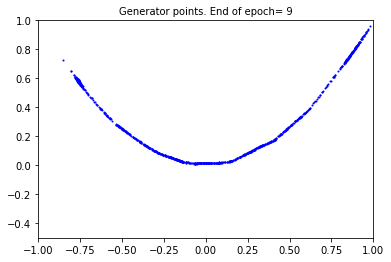

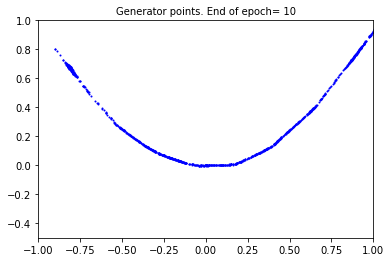

In [ ]:
train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG)

Сеть отлично обучилась при подаче в дискриминатор всех типов точек. Можно отключить некоторые типы и посмотреть что получится.

In [ ]:
def train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG):
    for epoch in range(epochs):
        for _ in range(batch_per_epoch):
            batchG = get_g_batch(batch_size, latent_dim)
            #batchD = get_mix_batch(batch_size, latent_dim, netG, add_uniform=True)

            #netD.train(True)
            #netG.train(False)
            #netD_step(netD, batchD, loss_func, optD)

            netD.train(False)
            netG.train(True)
            netG_step(netD, netG, batchG, loss_func, optG)

        # clear_output()
        plot_gen(netG, epoch)

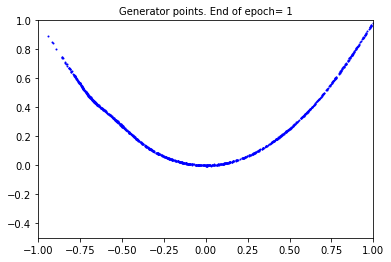

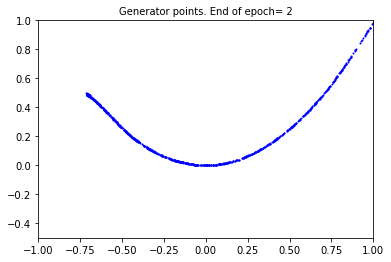

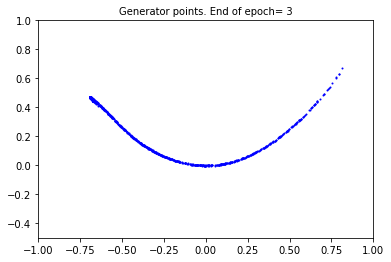

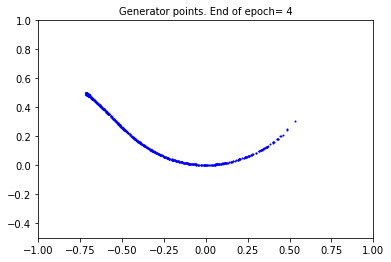

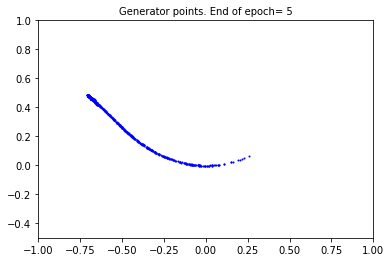

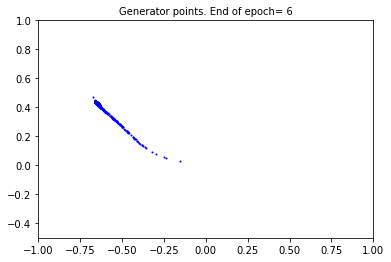

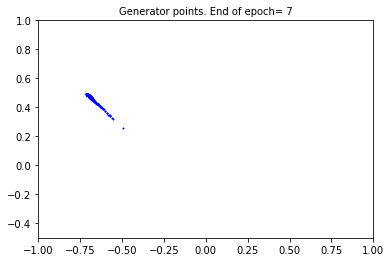

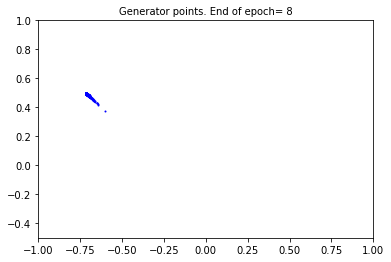

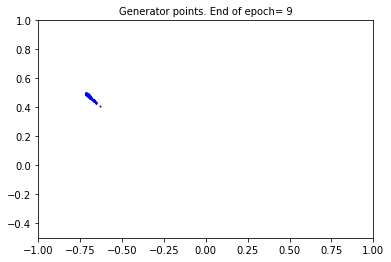

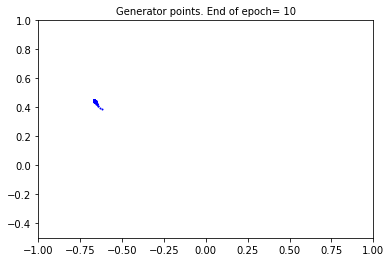

In [ ]:
train(netD, netG, batch_per_epoch, batch_size, latent_dim, epochs, loss_func, optD, optG)

## DCGAN - Генерация изображений

С помощью GAN можно, разумеется, генерировать не только точки на параболе. Можно генерировать, например, изображения.

Для этого нам снова помогут разжимающие сверточные блоки -- Upsample и ConvTranspose2d.



<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/dcgan.png" alt="Drawing" width= "900px;"/>

## cGAN - GAN с условием

Изучая автоэнкодеры, мы отдельное внимание уделили cVAE -- автоэнкодерам с условием. Напрямую подавая метку на декодировщик, мы помогали нашей сети не тратить силы и веса на разделение объектов разных классов в латентном пространстве, в результате чего она для каждого класса смогла выучить отдельное представление, учитывающее только разброс по вариантам объектов в этом классе. Это позволило нам использовать обученный автоэнкодер для задач переноса стиля, избавило нас от проблем с различением слишком близких классов и тд.

Подобную схему с передачей меток классов мы можем применить и в случае генеративно-состязательных сетей. Условие может быть любым, например, генерация конкретной цифры. Разумеется, в этом случае нам для обучения дискриминатора потребуется уже размеченный датасет.


<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/gan_conditional_scheme.png" alt="Drawing" width= "800px;"/>

Уловием в данном случае будет метка класса или label, которая на рисунке обозначена Y. Label добавляется к случайному шуму, тем самым мы говорим генератору генерировать случайное изображение нужного класса. Так же он подаётся в дискриминатор в качестве входа, чтобы дискриминатор знал какое изображение классифицировать как реальное, а какое как вымышленное.






### Text to image

Мы можем подавать модели на вход и не случайный шум, а  некое описание объекта, который хотим получить (например, вектор заданных свойств: Класс объекта, Углы и повороты, Заданные параметры трансформаций, Сегментация).

Описание может быть представлено в виде естественного текста.  Цель состоит в том, чтобы генерировать изображения из текста, а также позволить пользователю манипулировать синтетическими изображениями, используя описания на естественном языке, в одной структуре.


Архитектуры сетей text-to-image преобразуют входной текст в эмбеддинг при помощи RNN или Transformer блоков на входе, после чего передают генератору/дискриминатору или ансамблю таких моделей. Один из примеров на PyTorch -- **ControlGAN** .

<a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8641270">Статья</a>


<a href="https://github.com/mrlibw/ControlGAN">Github</a>



<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/example_archi.jpg" alt="Drawing" width= "900px;"/>



В ноябре 2021 NVIDIA <a href="https://blogs.nvidia.com/blog/2021/11/22/gaugan2-ai-art-demo/">показали</a> GauGAN2 -- модификацию одной из своих предыдущих разработок, позволяющую получать генерировать фотореалистичные изображения по текстовому описанию. Кстати, попробовать модель в деле можно <a href="https://www.nvidia.com/en-us/research/ai-demos/">здесь</a>.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/gaugan_output.jpg" alt="Drawing" width= "600px;"/>



Стоит отметить, что далеко не любые Text-to-image модели являются по своей сути GAN: например, широко известная <a href="https://openai.com/blog/dall-e">DALL·E</a> от OpenAI и ее русскоязычный <a href="https://rudalle.ru/">аналог</a> от Сбера основаны на архитектуре GPT, которая является трансформером.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/example_dall-e.png" alt="Drawing" width= "700px;"/>

## Генерация структур химических веществ.

В биологии нам не очень часто нужно генерировать картинки. Гораздо более актуальна идея генерации структур различных веществ (в частности, малых молекул). Делать это можно разными способами под разные задачи, очень многое зависит от представления данных и решаемой задачи. Отдельно стоит отметить успех архитектур на графовых слоях (о них мы поговорим в конце нашего курса).

Хороший и наглядный пример генератора малых молекул на основе графовых сверток и лосса Вассерштейна:

https://keras.io/examples/generative/wgan-graphs/

Написано на Keras, однако, зная PyTorch, вполне нетрудно разобраться с тем, что происходит:

<a href="https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/wgan-graphs.ipynb">Пример использования</a>


<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/example_wgan_gp.png" alt="Drawing" width= "600px;"/>





Пример очевидно игрушечный, однако генерация веществ с **заданными свойствами** под **заданный белок** - огромный хайп и под это делается много статей. Например -- <a href="https://www.nature.com/articles/s41587-019-0224-x
">статья</a> Insilico Medicine про генерацию ингибиторов киназы DDR1 с использованием подхода reinforcement learning.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/example_insilico.webp" alt="Drawing" width= "800px;"/>

## *Дополнительно: модификации GAN

Разных вариаций GAN было придумано неимоверное количество. Перечислять их все не хватит никакого времени, например заметен рост новых решений для распознавания или сегментации с использованием идей GAN. Подробнее можно почитать, например <a href="https://paperswithcode.com/methods/category/generative-models">тут</a>.

Несколько вариаций, которые хочется упомянуть:

* **EBGAN** (Energy-based Generative Adversarial Network) рассматривает дискриминатор как функцию энергии, которая приписывает низкие энергии областям вблизи области, соотвествующей нашим данным, и более высокие энергии другим регионам, подобно вероятностным моделям. Таким образом, от генератора мы будем ждать создания объектов с минимальными значениями "энергии".

* **InfoGAN**: не подаем label в дискриминатор, а ждем от него классификации в соответствии с классом, который мы хотим получить от генератора.

*  **AC-GAN** (auxiliary classifier) различие заключается в том, что дискриминатор дожен помимо распознавания реальных и фейковых изображений ещё и классифицировать их. Он имеет эффект стабилизации процесса обучения и позволяет генерировать большие высококачественные изображения, изучая представление в скрытом пространстве, которое не зависит от метки класса.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/gan_flavors.png" alt="Drawing" width= "800px;"/>

<a href="https://giters.com/hussain7/tensorflow-generative-model-collections">Source</a>

## **Дополнительно: AAE

Оказывается, что GAN и VAE можно "скрестить". Такие нейросети называются **adversarial autoencoders**. В случае VAE нам нужно было требовать от генерируемого многомерного распределения быть близким к нормальному, чтобы кодировщик не мог "схалтурить" и занулить вектора генерируемых стандартных отклонений, тем самым сведя получаемые распределения к отдельным точкам. Для этого мы в качестве второй компоненты лосса использовали KL-дивергенцию, которая и требовала от получаемых векторов в латентном пространстве быть близким к взятым из нормального распределения. У такого подхода много проблем, в том числе неидеальна и сама KL-дивергенция. Можно попробовать заменить её на дискриминатор -- теперь он будет отличать латентное представление, которое мы сгенерировали от стандартного нормального распределения. Если может отличить хорошо — то штрафуем энкодер за это.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/adversarial_ae.png" alt="AAE pic" width= "800px;"/>
<a href="https://medium.com/vitrox-publication/adversarial-auto-encoder-aae-a3fc86f71758">Source</a>

Внезапно, это избавляет нас от необходимости даже делать какие-то дополнительные манипуляции с кодировщиком — нам не нужно теперь, чтобы он выдавал средние и дисперсии, а потом мы использовали их для генерации объектов из реального распределения. Нам достаточно того, что дискриминатор не может отличить латентное представление, которое мы получаем от нормального распределения.

Более того, оказывается, что AAE может генерировать более «качественные» объекты, нежели ванильный VAE. Можно теоретически показать, что это является следствием того, что он минимизирует не KL-divergence, а более эффективную дивергенцию Йенсена-Шеннона. Однако подробный разбор этого выходит за рамки курса.

Кроме того, для AAE легче добиться того, чтобы ваше латентное представление выглядело специфичным образом. Просто генерируем выборку из нужного  (не обязательно нормального!) распределения и говорим дискриминатору пытаться отличать сгенерированную выборку от объектов из латентного представления.

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/aae_usage.png" alt="AAE pic 2" width= "700px;"/>



Ещё одна статья от Insilico про генерацию новых химических веществ, на этот раз с использованием ААЕ -- [druGAN](https://pubs.acs.org/doi/10.1021/acs.molpharmaceut.7b00346).

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/example_drugan.webp"/>





## Style GAN

https://arxiv.org/pdf/1812.04948.pdf

Есть семейство нейросетей, основанных на генеративных состязательных сетях, которые генерят очень качественные изображения



![image.png](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/example_stylegan.png)

Это схема первого StyleGAN. Дальнейшие сети улучшали подход, который использовался в первой архитектуре

![image.png](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/example_stylegan_architecture.png)

## VQGAN+CLIP

https://arxiv.org/pdf/2204.08583.pdf

<img src="https://github.com/nerdyrodent/VQGAN-CLIP/raw/main/samples/vvg_picasso.png">

У нас есть есть сеть, умеющая генерировать изображение из шума (VQGAN). Она не умеет понимать текст. И у нас есть сеть, которая умеет говорить, насколько данное текстовое описание похоже на данную ей на вход картинку (CLIP). С помощью этой сети генерируем так:

1. VQGAN генерирует какую-то случайную картинку на основе вектора Z (изначально он или случаен или получен из изображения-основы).

2. CLIP оценивает, насколько сгенерированная картинка похожа не текстовая описание и сообщает об этом VQGAN, вектор Z немного меняется с учетом этого.

3. Возвращаемся к первому шагу.

Как получена CLIP, мы с вами обсудим позднее

![example_vqgan_principle.png](https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/example_vqgan_principle.png)

<img src="https://data.bioml.ru/htdocs/courses/bioml/neural_networks/gan/img/example_vqgan_anim.gif">